In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.ndimage import binary_erosion, binary_dilation, grey_erosion
from skimage import transform
import cv2 
import skimage.transform as skTrans
from skimage.transform import resize
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.ndimage import binary_erosion, binary_dilation, grey_erosion
from skimage import transform
import cv2 
import skimage.transform as skTrans
from skimage.transform import resize

def uniformal_slices(nifti_data, target_slices=12, target_height=None, target_width=None):
    '''
    Resize the data to have a uniform number of slices
    '''
    num_slices = nifti_data.shape[0]
    if num_slices == target_slices:
        return nifti_data

    interpolation_factor = num_slices / target_slices
    interpolated_slices = []
    
    for i in range(target_slices):
        slice_index = int(i * interpolation_factor)
        interpolated_slices.append(nifti_data[slice_index])

    interpolated_data = np.array(interpolated_slices)
    
    if target_height is None or target_width is None:
        target_height = nifti_data.shape[1]
        target_width = nifti_data.shape[2]
    resized_data = np.zeros((target_slices, target_height, target_width), dtype=nifti_data.dtype)
    
    for i in range(target_slices):
        resized_data[i] = resize(interpolated_data[i], (target_height, target_width))
        
    return resized_data

def resize_predictions(nifti_data,  max_height = 128 , max_width = 128):
    '''
    Resize predictions
    '''
    slices, height, width = nifti_data.shape
    new_height = max_height
    new_width = max_width
    reshaped_data = np.reshape(nifti_data, (slices * height, width))
    resized_data = skTrans.resize(reshaped_data, (slices * new_height, new_width), order=1, preserve_range=True)
    nifti_data = np.reshape(resized_data, (slices, new_height, new_width))
    return nifti_data

def extract_segmentation_boundaries(segmentation_array):
    '''
    Extract the segmentationboundaries
    '''
    threshold = 0.1 # Adjust this threshold based on your segmentation values
    binary_mask = segmentation_array > threshold
    binary_mask = binary_mask.astype(int)
    return binary_mask



def select_slices_with_large_mask(or_array, pred_array, binary_masks, min_true_area):
    selected_slices_or_array = []
    selected_slices_predarray = []
    for i, binary_mask in enumerate(binary_masks):
        true_area = np.sum(binary_mask)
        if true_area >= min_true_area:
            selected_slices_or_array.append(or_array[i])
            selected_slices_predarray.append(pred_array[i])
    if not selected_slices_or_array:  # Check if any slices were selected
        return or_array, pred_array  # Return None or handle the case appropriately
    return np.stack(selected_slices_or_array), np.stack(selected_slices_predarray)



In [2]:
#Path to the myocardium predictions to iterate through
filenames = os.listdir(r"\myo_pred_all_lge\\")
filenames = [filename.translate(str.maketrans("", "", "'")) for filename in filenames]

original_images = []
original_images_cr = []
binary_masks = []
binary_masks_cr = []
for count, file in enumerate(filenames):
    if count > 1:
           break
    img =  file[:-14]
    or_img = sitk.ReadImage(r'\lge_sax_psir_mri_good\{}.nii'.format(img))
    pred_img = sitk.ReadImage(r'\myo_pred_all_lge\\' + file)
    
    or_array = sitk.GetArrayFromImage(or_img)
    pred_array = sitk.GetArrayFromImage(pred_img)

    binary_mask = (pred_array > 0.1).astype(int)
    or_array, pred_array = select_slices_with_large_mask(or_array, pred_array, binary_mask, min_true_area=15)
    
    pred_array = uniformal_slices(pred_array,target_slices=12)
    or_array = uniformal_slices(or_array, target_slices=12)

    pred_array = resize_predictions(pred_array, max_height = 256, max_width = 256)
    or_array = resize_predictions(or_array, max_height = 256, max_width = 256)

    binary_mask = extract_segmentation_boundaries(pred_array)
    binary_mask = resize_predictions(binary_mask, max_height = 256, max_width = 256)

    
    binary_masks.append(binary_mask)
    original_images.append(or_array)
    

     

In [3]:
cropped_images = np.stack(original_images)
binary_matrix = np.stack(binary_masks)
original_images_10sl = cropped_images
binary_matrix_10sl = binary_matrix


In [4]:
cropped_images = np.stack(original_images)
cropped_images.shape

(2, 12, 256, 256)

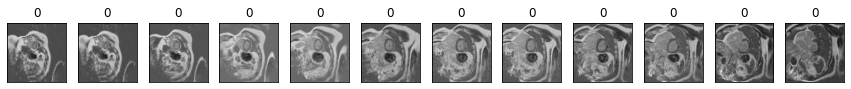

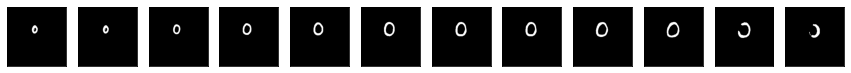

In [5]:
for j in range(1):
    fig, axs = plt.subplots(1, 12, figsize=(15, 5))
    for i in range(12):
        axs[i].imshow(original_images_10sl[j, i, :, :], cmap='gray')
        axs[i].set_title(j)
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

    fig, axs = plt.subplots(1, 12, figsize=(15, 5))
    for i in range(12):
        axs[i].imshow(binary_matrix_10sl[j, i, :, :], cmap='gray')
        axs[i].set_title("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

In [7]:
import numpy as np
from skimage import transform, morphology
import pandas as pd
original_images_cr = []
binary_masks_cr = []
counter_none =0

for i in range(original_images_10sl.shape[0]):
    no_value_mask_found = False  # Flag to track if no-value (all zeros) mask is found
    invalid_slices = []

    for j in range(original_images_10sl.shape[1]):
        if not np.any(binary_matrix_10sl[i, j]):
            no_value_mask_found = True
            break  # Skip processing this patient
        
        mask = binary_matrix_10sl[i, j].astype(bool)
        if not mask.any():
            invalid_slices.append(j)
        
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) != 1:
            invalid_slices.append(j)
            
    if no_value_mask_found:
        counter_none += 1
      #  continue

    cropped_images = []
    cropped_masks = []

    min_row, min_col, max_row, max_col = float('inf'), float('inf'), 0, 0  # Initialize bounding box coordinates

    for j in range(original_images_10sl.shape[1]):
        #if j not in invalid_slices:
        rows, cols = np.nonzero(binary_matrix_10sl[i, j])
        if len(rows) > 0 and len(cols) > 0:
            min_row = min(min_row, np.min(rows))
            min_col = min(min_col, np.min(cols))
            max_row = max(max_row, np.max(rows))
            max_col = max(max_col, np.max(cols))

    for j in range(original_images_10sl.shape[1]):
        try:

            cropped_image = original_images_10sl[i, j, int(min_row):int(max_row)+1, int(min_col):int(max_col)+1]
            cropped_mask = binary_matrix_10sl[i, j, int(min_row):int(max_row)+1, int(min_col):int(max_col)+1]

            cropped_image = transform.resize(cropped_image, (256, 256), preserve_range=True, anti_aliasing=True)
            cropped_mask = transform.resize(cropped_mask, (256, 256), preserve_range=True, anti_aliasing=True)

            cropped_images.append(cropped_image)
            cropped_masks.append(cropped_mask)
        except:
            if np.isinf(min_row) or np.isinf(min_col) or np.isinf(max_row) or np.isinf(max_col):
                cropped_image = original_images_10sl[i, j, :, : ]
                cropped_mask = binary_matrix_10sl[i, j, :, : ]
                cropped_images.append(cropped_image)
                cropped_masks.append(cropped_mask)    # Append cropped images and masks to lists
    #correctly_cropped_df.loc[len(correctly_cropped_df)] = log_mask.loc[i]
    
    original_images_cr.append(cropped_images)
    binary_masks_cr.append(cropped_masks)

original_images_cr = np.array(original_images_cr)
binary_masks_cr = np.array(binary_masks_cr)

print(original_images_cr.shape)
print(binary_masks_cr.shape)

(2, 12, 256, 256)
(2, 12, 256, 256)


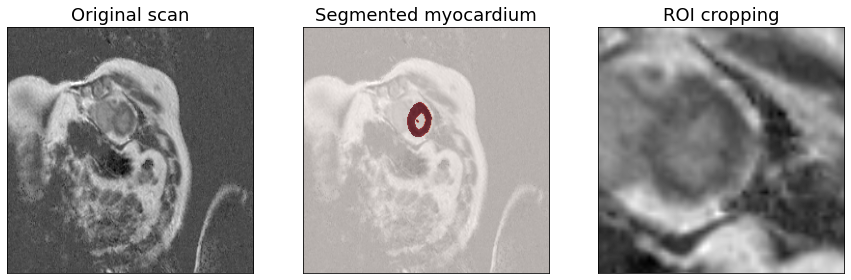

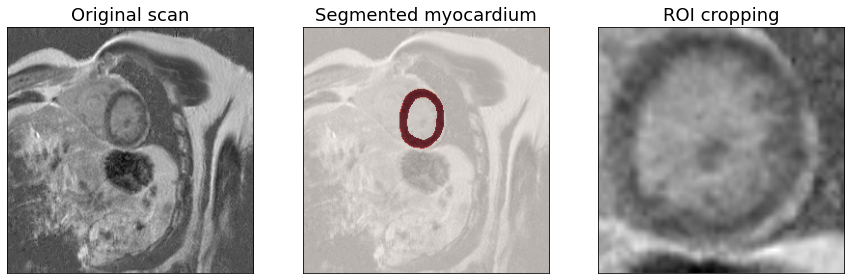

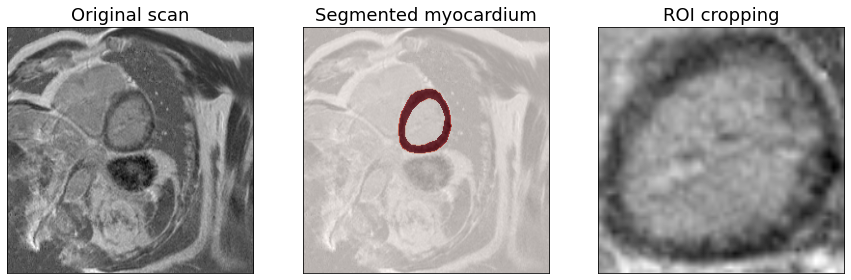

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for p in range(1):
    for i in range(1, 10, 4):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(original_images_10sl[p, i, :, :] , cmap='gray')
        axs[0].set_title("Original scan", fontsize=18)
        axs[2].imshow(original_images_cr[p, i, :, :], cmap='gray')
        axs[2].set_title("ROI cropping", fontsize=18)
        axs[1].imshow(binary_matrix_10sl[p, i, :, :], cmap='Reds')
        axs[1].imshow(original_images_10sl[p, i, :, :], alpha=0.4, cmap='gray')
        axs[1].set_title("Segmented myocardium", fontsize=18)
        axs[1].set_yticks([])
        axs[1].set_xticks([])

        axs[0].set_yticks([])
        axs[0].set_xticks([])
        
        axs[2].set_yticks([])
        axs[2].set_xticks([])
        
        plt.show()
        plt.close(fig)


In [12]:
import numpy as np
from skimage import exposure

def hist_equalization(data):
    equalized_slices = np.zeros_like(data)
    for i in range(data.shape[0]):
        equalized_slices[i] = exposure.equalize_hist(data[i])
        
    return equalized_slices

def z_score_normalize(data):
    mean = np.mean(data, axis=(2,3), keepdims=True)
    std = np.std(data, axis=(2,3), keepdims=True)
    epsilon = 1e-10
    normalized_slices = (data - mean) / (std + epsilon)
    return normalized_slices

normalized_mri_data = z_score_normalize(original_images_cr)
equalized_mri_data = hist_equalization(normalized_mri_data)


In [14]:
new_height = 64
new_width = 64

resized_images_np = np.zeros((equalized_mri_data.shape[0], equalized_mri_data.shape[1], new_height, new_width))
for i in range(equalized_mri_data.shape[0]):
    for j in range(equalized_mri_data.shape[1]):
        resized_images_np[i, j] = cv2.resize(equalized_mri_data[i, j], dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC)

# Convert numpy array back to tensor
resized_MRI = torch.from_numpy(resized_images_np)
print(resized_MRI.shape)

resized_images_np = np.zeros((binary_masks_cr.shape[0], binary_masks_cr.shape[1], new_height, new_width))
for i in range(binary_masks_cr.shape[0]):
    for j in range(binary_masks_cr.shape[1]):
        resized_images_np[i, j] = cv2.resize(binary_masks_cr[i, j], dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC)

resized_masks = torch.from_numpy(resized_images_np)
print(resized_masks.shape)

torch.Size([2, 12, 64, 64])
torch.Size([2, 12, 64, 64])


# 